![CH5-ADS.png](.\Media\CH5-ADS.png)

# <span style="color:#cc5500;">Consistency Checks</span>

- "Consistency" means that something is as it is supposed to be
    - E.g. if data page X, in the leaf level of a clustered index points to data page Y as being the next page in the index, thn page Y should exist, should be part of the index, and should have the correct key values on it
- "Consistency checking" in the context of SQL Server means running a process that validates the consistency
    - Usually this means running DBCC CHECKDB which will be covered in a seperate notebook

## <span style="color:#cc5500;">Which Databases Should Be Checked?</span>

- All databases should be consistency checked, Including read-only databases
- Include system databases
    - master, as it contains information about databases, users, logins
    - Corruptions in it can cause an instance to fail to start
    - mssqlsystemresourceis checked automatically when master is checked
    - msdb, as it contains SQL Agent jobs, schedules, backup history, and more
    - model, as its content is copied to create new databases
    - tempdb, as corruptions in it can cause an instance to shut down
    - Note that if you use the Maintenance Plan Wizard to create a job to check integrity, tempdbis excluded so you need to manually create an agent job to do this
    - distribution, to avoid replication problems

## <span style="color:#cc5500;">How to run Consistency Checks</span>

Three options for running consistency checks:

- Manually
- Automated script, using SQL Agent
- Automated using a SQL Server Maintenance Plan

It is highly recommend that you take advantage of the free, widely used, and easy-to-use set of maintenance scripts available from Ola Hallengren at [http://ola.hallengren.com/](http://ola.hallengren.com/)

## <span style="color:#cc5500;">How Often Should Consistency Checks be Run?</span>

It all depends on a combination of:

- Stability of I/O subsystem
- Backup strategy
- Acceptable downtime if corruption occurs
- Acceptable data loss if corruption occurs
- Time window available to take the extra I/O and CPU load
- What kind of system it is (e.g. production, test, backup)

I always like to recommend at least once a week

Some people advocate consistency checking a mirror database or an availability group secondary replica as a way of consistency checking the principal database or primary replica

### <span style="color:#e32636;">That view is not valid.&nbsp; Why?</span>

- The various servers are stored on different I/O subsystems and corruptions do not propagate between servers
    - E.g. ensuring that a mirror database has no corruption does not imply anything about the state of the principal database
- Consistency checking should ideally be performed on all copies of a database
    - Especially true for availability groups if a secondary replica is being used to offload full backups from the primary replica

## <span style="color:#cc5500;">Backup Checksums</span>

- Use BACKUP WITH CHECKSUM when performing a backup
    - It validates all page checksums in the database as the pages are read
    - It calculates a checksum over the entire backup stream and records it in the backup header
    - Has negligible performance impact
    - Gives you peace of mind that no I/O errors are present in the database
    - I recommend you always do this
- Allows the integrity of the backup to be checked using RESTORE VERIFYONLY… WITH CHECKSUM
    - Gives you peace of mind that no I/O errors are present in the backup
    - Backups are susceptible to I/O subsystem corruption just like data files
- Allows page checksums to be checked during restore operations.  The restore will fail if it comes across a bad checksum

# <span style="color:#cc5500;">Bad Checksum Demo</span>

## <span style="color:#da2433;">DISCLAIMER: This Demo purposefully corrupts a test database!!&nbsp; The information in this section should not be used on a production SQL Server system. Any problem, corruption, damage, or loss you cause by using the information presented here is entirely your own responsibility. Use at your own risk.&nbsp; If DBCC WRITEPAGE is run against the master database, it can cause your SQL Server to shut down and not start again until master is repair.&nbsp; It is highly recommended that you perform this on a test system.</span>

Use on a Test User Database on a Test Server, and not on a System database.

This setup script uses the undocumented DBCC WRITEPAGE command against a test database to cause corruption and the undocumented DBCC IND command to find pages to corrupt.  These two DBCC's were created by the Microsoft Product Group in order to create DBCC CHECKDB that is used in the repair of a database.

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set

In [ ]:
-- Setup script for Backup Checksums demo.

-- This setup script uses the undocumented DBCC WRITEPAGE command to cause corruption and the undocumented DBCC IND command to find pages to corrupt. 
-- Drop and then Create the 2 test databases
USE [master];
GO

IF DATABASEPROPERTYEX (N'Company', N'Version') > 0
BEGIN
	ALTER DATABASE [Company] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [Company];
END
GO

IF DATABASEPROPERTYEX (N'Company2', N'Version') > 0
BEGIN
	ALTER DATABASE [Company2] SET SINGLE_USER
		WITH ROLLBACK IMMEDIATE;
	DROP DATABASE [Company2];
END
GO

--Modify the file path for your environment and create the database
CREATE DATABASE [Company] ON PRIMARY (
    NAME = N'Company',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company.mdf')
LOG ON (
    NAME = N'Company_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company_log.ldf');
GO

CREATE DATABASE [Company2] ON PRIMARY (
    NAME = N'Company2',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company2.mdf')
LOG ON (
    NAME = N'Company2_log',
    FILENAME = N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company2_log.ldf');
GO

In [ ]:
-- Create a table in each database and insert data
USE [Company];
GO

CREATE TABLE [RandomData] (
	[c1]  INT IDENTITY,
	[c2]  CHAR (8000) DEFAULT 'a');
GO

INSERT INTO [RandomData] DEFAULT VALUES;
GO 10

USE [Company2];
GO

CREATE TABLE [RandomData] (
	[c1]  INT IDENTITY,
	[c2]  CHAR (8000) DEFAULT 'a');
GO

INSERT INTO [RandomData] DEFAULT VALUES;
GO 10


In [ ]:
-- List the pages in the table
DBCC IND (N'Company2', N'RandomData', -1);
GO



Pick a data page to corrupt.

  

Your query will return different values, but in my case, I'm going to choose  PageFID 1 and PagePID 363

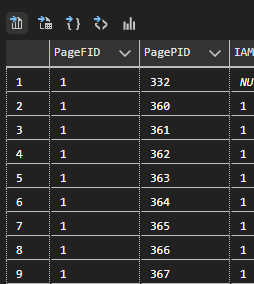

In [ ]:
-- Pick a page in Company2 to corrupt
-- Just replace the two values for B, B  the remaining values in place   (N'Company2', B, B, 0, 2, 0x0000, 1);
ALTER DATABASE [Company2] SET SINGLE_USER;
GO
DBCC WRITEPAGE (N'Company2', 1, 363, 0, 2, 0x0000, 1);
GO
ALTER DATABASE [Company2] SET MULTI_USER;
GO


In [ ]:
-- Do some cleanup before the demo
-- Clean the error log and suspect_pages
DELETE FROM [msdb].[dbo].[suspect_pages];
EXEC sp_cycle_errorlog;
GO

Now that we have picked a page to Corrupt, cleared out the msdb suspect\_pages table, and cycled the error log, We are now ready for the Bad Checksum demo

### <span style="color:rgb(0, 204, 153);">Run the Code block below</span>

1. Click the run icon below
2. If ADS prompts you for a connection, enter the correct SQL Server and authentication account
3. View the results of the query by scrolling down to the results set


In [ ]:
-- Back up both databases
BACKUP DATABASE [Company]
TO DISK = N'C:\Temp\Backups\Company.bak'  --Modify this path for your environment
WITH INIT;
GO

BACKUP DATABASE [Company2]
TO DISK = N'C:\Temp\Backups\Company2.bak'  --Modify this path for your environment
WITH INIT;
GO

Notice that nothing unusual happened.  SQL is reporting a normal backup, but since you corrupted a page in Company2, you know that your backup, just backed up a corrupted page to the backup file.

Now, we will perform a BACKUP WITH CHECKSUM

In [ ]:
-- Now use WITH CHECKSUM
BACKUP DATABASE [Company]
TO DISK = N'C:\Temp\Backups\Company_CHECKSUM.bak' --Modify this path for your environment
WITH INIT, CHECKSUM;
GO

BACKUP DATABASE [Company2]
TO DISK = N'C:\Temp\Backups\Company2_CHECKSUM.bak' --Modify this path for your environment
WITH INIT, CHECKSUM;
GO

Notice that the backup process terminated during the backup of Company2 since it detected an error on a data page.  Using CHECKSUM allows you to detect issues.  This is 'good', you want your backups to fail, if an error is detected.  If you have a need, you can force the backup to occur using CONTINUE but this will be covered in further detail a more advanced notebook later.

In [ ]:
-- CONTINUE_AFTER_ERROR can be used to force the backup.
BACKUP DATABASE [Company2]
TO DISK = N'C:\Temp\Backups\Company2_CHECKSUM.bak'
WITH INIT, CHECKSUM, CONTINUE_AFTER_ERROR;
GO

You will see that the backup did occur, but that is backed up a damaged database.  If you look at your SQL Error Log you will see the message:

_BACKUP 'Company2' detected an error on page (1:363) in file 'C:\\Program Files\\Microsoft SQL Server\\MSSQL14.VIPER\\MSSQL\\DATA\\Company2.mdf'._

In [ ]:
-- Look in the backup header
RESTORE HEADERONLY
FROM DISK = N'C:\Temp\Backups\Company2_CHECKSUM.bak';
GO

If you review the result of the HEADERONLY query, you will see that the IsDamaged field is set to 1

In [ ]:
RESTORE VERIFYONLY
FROM DISK = N'C:\Temp\Backups\Company2_CHECKSUM.bak'
WITH CHECKSUM;
GO

The results of the VERIFYONLY query show: <span style="font-size: 12px;"><i>The backup set was written with damaged data by a BACKUP WITH CONTINUE_AFTER_ERROR</i></span>

<span style="font-size: 12px;">You can force a Database Restore using Continue.&nbsp; Here is a sample and more will be covered on this in an advanced notebook later.&nbsp; Looks the the results of this last query and you will see that the Database Restore Completed and that damage was encountered resulting in potential inconsistencies.</span>

In [ ]:
-- CONTINUE_AFTER_ERROR can be used to force the restore.
-- Discussed more in an Advanced Corruption Recovery Notebook
RESTORE DATABASE [Company2_Copy]
FROM DISK = N'C:\Temp\Backups\Company2_CHECKSUM.bak'
WITH
    MOVE N'Company2' TO N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company2_Copy.mdf',
	MOVE N'Company2_log' TO N'C:\Program Files\Microsoft SQL Server\MSSQL14.VIPER\MSSQL\DATA\Company2_Copy_log.ldf',
	REPLACE, CONTINUE_AFTER_ERROR;
GO


## <span style="color:#cc5500;">A few final thoughts</span>

Backup Checksums vs. Consistency Checks

- Some people advocate using backup checksums as a replacement for consistency checks

### <span style="color:#e32636;">That view is not valid.&nbsp; Why?</span>

- Although backup checksums will find problems caused by the I/O subsystem, what if the page was corrupt before it was written to disk?
- For example:
    - Page in memory gets corrupted by bad memory chip
    - Page is then written to disk by the buffer pool
    - The page will have a valid page checksum, but the contents are corrupt
- <u>**ONLY**</u> consistency checks using DBCC can detect this